In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
%matplotlib inline
from matplotlib import pyplot
import numpy as np
import os
import shutil
import operator
import caffe2.python.predictor.predictor_exporter as pe

from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])
print("Necessities imported!")

net_drawer will not run correctly. Please install the correct dependencies.
Necessities imported!


In [2]:
def AddInput(model, batch_size, db, db_type):
    ### load the data from db - Method 1 using brew
    #data_uint8, label = brew.db_input(
    #    model,
    #    blobs_out=["data_uint8", "label"],
    #    batch_size=batch_size,
    #    db=db,
    #    db_type=db_type,
    #)
    ### load the data from db - Method 2 using TensorProtosDB
    data_uint8, label = model.TensorProtosDBInput(
        [], ["data_uint8", "label"], batch_size=batch_size,
        db=db, db_type=db_type)
    # cast the data to float
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

In [223]:
def myNet(model, data):
    fc6 = brew.fc(model, data, 'fc6', dim_in=41, dim_out=20) #12544   25088   35  12579
    relu6 = brew.relu(model, fc6, 'relu6')
    #fc7 = brew.fc(model, relu6, 'fc7', dim_in=1024, dim_out=100) #1024
    #relu7 = brew.relu(model, fc7, 'relu7')
    # Last FC Layer
    pred = brew.fc(model, relu6, 'pred', dim_in=20, dim_out=2)
    # Softmax Layer
    softmax = brew.softmax(model, pred, 'softmax')
    return softmax

In [224]:
def AddTrainingOperators(model, softmax, label):
    """Adds training operators to the model."""
    # Compute cross entropy between softmax scores and labels
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    # Compute the expected loss
    loss = model.AveragedLoss(xent, "loss")
    # Track the accuracy of the model
    brew.accuracy(model, [softmax, label], "accuracy")
    # Use the average loss we just computed to add gradient operators to the model
    model.AddGradientOperators([loss])
    # Specify the optimization algorithm
    optimizer.build_sgd(
        model,
        base_learning_rate=0.0005,
        policy="step",
        stepsize=1,
        gamma=0.999,
    )

In [225]:
def AddBookkeepingOperators(model):
    """This adds a few bookkeeping operators that we can inspect later.
    
    These operators do not affect the training procedure: they only collect
    statistics and prints them to file or to logs.
    """    
    # Print basically prints out the content of the blob. to_file=1 routes the
    # printed output to a file. The file is going to be stored under
    #     root_folder/[blob name]
    model.Print('accuracy', [], to_file=1)
    model.Print('loss', [], to_file=1)
    # Summarizes the parameters. Different from Print, Summarize gives some
    # statistics of the parameter, such as mean, std, min and max.
    #for param in model.params:
    #    model.Summarize(param, [], to_file=1)
    #    model.Summarize(model.param_to_grad[param], [], to_file=1)

### Train Model

In [226]:
dataset = "/home/hercules/Documents/detectron/extract-features/reading_gray_kps" # + "_train.minidb" old/merged_sit_hm40_ggl70

In [227]:
# the data will be input in NCHW order, i.e. [batch_size, num_channels, height, width]
arg_scope = {"order": "NCHW"}
train_model = model_helper.ModelHelper(name="model_train", arg_scope=arg_scope)
# Specify the input is from the train lmdb
data, label = AddInput(
    train_model, batch_size=500,
    db= dataset + "_train.minidb",
    db_type="minidb")

In [228]:
softmax = myNet(train_model, data)
AddTrainingOperators(train_model, softmax, label)
AddBookkeepingOperators(train_model)

Iter: 0, Loss: 0.5770319104194641, Accuracy: 0.9919999837875366
Iter: 25, Loss: 0.7390655875205994, Accuracy: 0.3779999911785126
Iter: 50, Loss: 0.8223563432693481, Accuracy: 0.02199999988079071


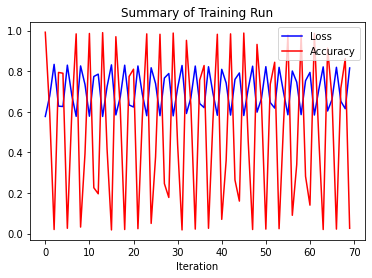

In [229]:
# The parameter initialization network only needs to be run once.
# Now all the parameter blobs are initialized in the workspace.
workspace.RunNetOnce(train_model.param_init_net)

# Creating an actual network as a C++ object in memory.
#   We need this as the object is going to be used a lot
#   so we avoid creating an object every single time it is used.
# overwrite=True allows you to run this cell several times and avoid errors
workspace.CreateNet(train_model.net, overwrite=True)

# Set the iterations number and track the accuracy & loss
total_iters = 70
accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)

# MAIN TRAINING LOOP!
# Now, we will manually run the network for 200 iterations. 
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    accuracy[i] = workspace.blobs['accuracy']
    loss[i] = workspace.blobs['loss']
    # Check the accuracy and loss every so often
    if i % 25 == 0:
        print("Iter: {}, Loss: {}, Accuracy: {}".format(i,loss[i],accuracy[i]))

# After the execution is done, let's plot the values.
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.title("Summary of Training Run")
pyplot.xlabel("Iteration")
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

### Testing model. 

In [203]:
# We will set the batch size to 100, so that the testing
#   pass is 100 iterations (10,000 images in total).
#   For the testing model, we need the data input part, the main AddModel
#   part, and an accuracy part. Note that init_params is set False because
#   we will be using the parameters obtained from the train model which will
#   already be in the workspace.
test_model = model_helper.ModelHelper(
    name="mnist_test", arg_scope=arg_scope, init_params=False)
data, label = AddInput(
    test_model, batch_size=150,
    db= dataset + "_test.minidb", #"test/sittingFull_test.minidb",#
    db_type="minidb")
softmax = myNet(test_model, data)
brew.accuracy(test_model, [softmax, label], "accuracy")

#### Deployment model. 
# We simply need the main AddModel part.
deploy_model = model_helper.ModelHelper(
    name="mnist_deploy", arg_scope=arg_scope, init_params=False)
myNet(deploy_model, "data")

BlobReference("softmax")

test_accuracy: 0.561333


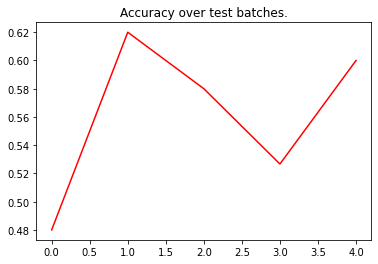

In [204]:
# param_init_net here will only create a data reader
# Other parameters won't be re-created because we selected init_params=False before
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)

# Testing Loop 
test_accuracy = np.zeros(5)
for i in range(5):
    # Run a forward pass of the net on the current batch
    workspace.RunNet(test_model.net)
    # Collect the batch accuracy from the workspace
    test_accuracy[i] = workspace.FetchBlob('accuracy')
    
# After the execution is done, let's plot the accuracy values.
pyplot.plot(test_accuracy, 'r')
pyplot.title('Accuracy over test batches.')
print('test_accuracy: %f' % test_accuracy.mean())

In [107]:
test_accuracy

array([0.51333332, 0.51333332, 0.49333334, 0.5       , 0.51333332])

In [10]:
labs = workspace.FetchBlob(core.ScopedName('label'))

In [12]:
labs[4]

0.0

In [10]:
workspace.blobs['accuracy']

array(0.515625, dtype=float32)

In [11]:
label = workspace.FetchBlob(core.ScopedName('label'))
label

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1], dtype=int32)

In [10]:
softmax = workspace.FetchBlob(core.ScopedName('softmax'))
softmax

array([[9.04978514e-01, 9.50215235e-02],
       [9.87935662e-01, 1.20643396e-02],
       [7.52634194e-04, 9.99247432e-01],
       [9.98045087e-01, 1.95490569e-03],
       [3.34834144e-03, 9.96651709e-01],
       [9.32075143e-01, 6.79248869e-02],
       [9.87603247e-01, 1.23967491e-02],
       [4.76867259e-02, 9.52313304e-01],
       [9.99777138e-01, 2.22931223e-04],
       [3.44603206e-03, 9.96554017e-01],
       [2.06806828e-04, 9.99793231e-01],
       [9.70461130e-01, 2.95388252e-02],
       [9.48462784e-01, 5.15371822e-02],
       [6.29787659e-03, 9.93702173e-01],
       [9.57037091e-01, 4.29629162e-02],
       [6.76375767e-03, 9.93236244e-01],
       [9.98140931e-01, 1.85909925e-03],
       [5.40745750e-05, 9.99945879e-01],
       [9.99391556e-01, 6.08426926e-04],
       [9.84578490e-01, 1.54214390e-02],
       [1.35222040e-02, 9.86477852e-01],
       [9.93235767e-01, 6.76424196e-03],
       [2.43641492e-02, 9.75635886e-01],
       [9.97964621e-01, 2.03540176e-03],
       [5.461796